In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

### Import regression data

In [4]:
# Open regression list data

import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_coef_c_new"), "rb") as fp:   #Pickling
    coef_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_coef_c_new"), "rb") as fp:   #Pickling
    coef_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_pval_c_new"), "rb") as fp:   #Pickling
    pval_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_pval_c_new"), "rb") as fp:   #Pickling
    pval_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_r2_c_new"), "rb") as fp:   #Pickling
    r2_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_r2_c_new"), "rb") as fp:   #Pickling
    r2_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_ypred_c_new"), "rb") as fp:   #Pickling
    pred_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_ypred_c_new"), "rb") as fp:   #Pickling
    pred_ridge_ssp = pickle.load(fp)

In [5]:
# MLR_b = ridge regression with residuals of pr,tas,enso,rsds,hfls \
# MLR_c = 5-fold CV Ridge Regression with resisuals of pr,tas,enso,rsds,hfls  \
# MLR_d = 5-fold CV Ridge Regression with resisuals of pr,tas,mrso,rsds and enso \
# MLR_e = 5-fold CV Ridge Regression with residuals of pr,tas,mrso,rsds,hfls and enso

# Because I forgot to concatenate the results of the MLR calculation 

coef_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_hist]
coef_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_ssp]

pval_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_hist]
pval_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_ssp]

pred_ridge_hist = [a.nep for a in pred_ridge_hist]
pred_ridge_ssp = [a.nep for a in pred_ridge_ssp]

In [6]:
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

## MultiModel mean and St Dev

In [7]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [8]:
# Mean response of ESM
coef_ridge_hist = xr_mean_list(coef_ridge_hist, esm)
coef_ridge_ssp = xr_mean_list(coef_ridge_ssp, esm)

pval_ridge_hist = xr_mean_list(pval_ridge_hist, esm)
pval_ridge_ssp = xr_mean_list(pval_ridge_ssp, esm)


Regrid to 1x1

In [9]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

coef_ridge_hist = [lon180(a) for a in coef_ridge_hist]
coef_ridge_ssp = [lon180(a) for a in coef_ridge_ssp]

ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 30, 1)

regrid = [xe.Regridder(a, ds_out, "bilinear") for a in coef_ridge_hist]

coef_ridge_hist = [reg(a, keep_attrs=True) for reg,a in zip(regrid,coef_ridge_hist)]
coef_ridge_ssp = [reg(a, keep_attrs=True) for reg,a in zip(regrid,coef_ridge_ssp)]

In [10]:
# Separate predictors HIST
coef_ridge_hist_pr = xr.concat([a.sel(coefficients = 0) for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_tas = xr.concat([a.sel(coefficients = 1).rename("tas") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_enso = xr.concat([a.sel(coefficients = 2).rename("enso") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_rsds = xr.concat([a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_hist],dim = "esm")
coef_ridge_hist_hfls = xr.concat([a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_hist],dim = "esm")

# Separate predictors SSP
coef_ridge_ssp_pr = xr.concat([a.sel(coefficients = 0) for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_tas = xr.concat([a.sel(coefficients = 1).rename("tas") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_enso = xr.concat([a.sel(coefficients = 2).rename("enso") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_rsds = xr.concat([a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_ssp],dim = "esm")
coef_ridge_ssp_hfls = xr.concat([a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_ssp],dim = "esm")


In [11]:
# Multimodel Mean and Std

coef_ridge_hist_pr_mean = coef_ridge_hist_pr.mean(dim = "esm")
coef_ridge_hist_tas_mean = coef_ridge_hist_tas.mean(dim = "esm")
coef_ridge_hist_enso_mean = coef_ridge_hist_enso.mean(dim = "esm")
coef_ridge_hist_rsds_mean = coef_ridge_hist_rsds.mean(dim = "esm")
coef_ridge_hist_hfls_mean = coef_ridge_hist_hfls.mean(dim = "esm")

coef_ridge_ssp_pr_mean = coef_ridge_ssp_pr.mean(dim = "esm")
coef_ridge_ssp_tas_mean = coef_ridge_ssp_tas.mean(dim = "esm")
coef_ridge_ssp_enso_mean = coef_ridge_ssp_enso.mean(dim = "esm")
coef_ridge_ssp_rsds_mean = coef_ridge_ssp_rsds.mean(dim = "esm")
coef_ridge_ssp_hfls_mean = coef_ridge_ssp_hfls.mean(dim = "esm")

coef_ridge_hist_pr_std = coef_ridge_hist_pr.std(dim = "esm")
coef_ridge_hist_tas_std = coef_ridge_hist_tas.std(dim = "esm")
coef_ridge_hist_enso_std = coef_ridge_hist_enso.std(dim = "esm")
coef_ridge_hist_rsds_std = coef_ridge_hist_rsds.std(dim = "esm")
coef_ridge_hist_hfls_std = coef_ridge_hist_hfls.std(dim = "esm")

coef_ridge_ssp_pr_std = coef_ridge_ssp_pr.std(dim = "esm")
coef_ridge_ssp_tas_std = coef_ridge_ssp_tas.std(dim = "esm")
coef_ridge_ssp_enso_std = coef_ridge_ssp_enso.std(dim = "esm")
coef_ridge_ssp_rsds_std = coef_ridge_ssp_rsds.std(dim = "esm")
coef_ridge_ssp_hfls_std = coef_ridge_ssp_hfls.std(dim = "esm")


Plot MM predictors mean and Std

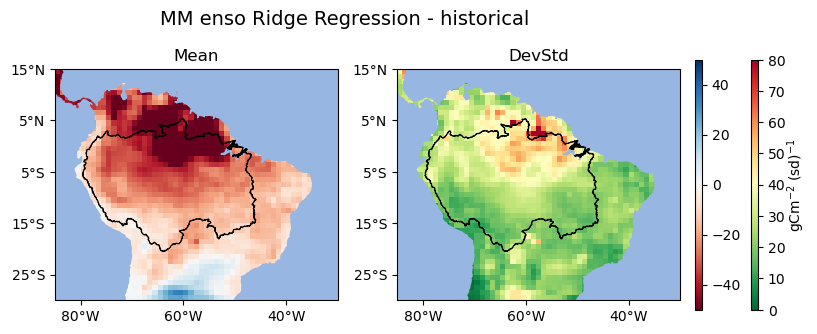

In [12]:
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

predictor = "enso"; scenario = "historical"

if scenario == "historical":
    if predictor == "pr":
        mean_plot = coef_ridge_hist_pr_mean; std_plot = coef_ridge_hist_pr_std; title = "MM Precipitation Ridge Regression - " + scenario 
    if predictor == "tas":
        mean_plot = coef_ridge_hist_tas_mean; std_plot = coef_ridge_hist_tas_std; title = "MM Temperature Ridge Regression - " + scenario
    if predictor == "enso":
        mean_plot = coef_ridge_hist_enso_mean; std_plot = coef_ridge_hist_enso_std; title = "MM enso Ridge Regression - " + scenario
    if predictor == "rsds":
        mean_plot = coef_ridge_hist_rsds_mean; std_plot = coef_ridge_hist_rsds_std; title = "MM Surface Shortwave Radiation Ridge Regression - " + scenario
    if predictor == "hfls":
        mean_plot = coef_ridge_hist_hfls_mean; std_plot = coef_ridge_hist_hfls_std; title = "MM Latent Heat Ridge Regression - " + scenario
else:
    if predictor == "pr":
        mean_plot = coef_ridge_ssp_pr_mean; std_plot = coef_ridge_ssp_pr_std; title = "MM Precipitation Ridge Regression - " + scenario
    if predictor == "tas":
        mean_plot = coef_ridge_ssp_tas_mean; std_plot = coef_ridge_ssp_tas_std; title = "MM Temperature Ridge Regression - " + scenario
    if predictor == "enso":
        mean_plot = coef_ridge_ssp_enso_mean; std_plot = coef_ridge_ssp_enso_std; title = "MM enso Ridge Regression - " + scenario
    if predictor == "rsds":
        mean_plot = coef_ridge_ssp_rsds_mean; std_plot = coef_ridge_ssp_rsds_std; title = "MM Surface Shortwave Radiation Ridge Regression - " + scenario
    if predictor == "hfls":
        mean_plot = coef_ridge_ssp_hfls_mean; std_plot = coef_ridge_ssp_hfls_std; title = "MM Latent Heat Ridge Regression - " + scenario

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(121, projection = ccrs.PlateCarree())

map = mean_plot.plot.pcolormesh(ax = ax1, x = "lon", y = "lat", cmap="RdBu", vmin=-50, vmax=50, 
                                                transform = ccrs.PlateCarree(), add_colorbar = False)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
ax1.add_feature(amz)
ax1.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
ax1.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_xlabel(""); ax1.set_ylabel("")
# Latitude labels
ax1.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax1.yaxis.set_major_formatter(lat_formatter)

ax2 = fig.add_subplot(122, projection = ccrs.PlateCarree())

map1 = std_plot.plot.pcolormesh(ax = ax2, x = "lon", y = "lat", cmap="RdYlGn_r", vmin=0, vmax=80, 
                                                transform = ccrs.PlateCarree(), add_colorbar = False)
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
ax2.add_feature(amz)
ax2.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
ax2.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.set_xlabel(""); ax2.set_ylabel("")
# Latitude labels
ax2.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax2.yaxis.set_major_formatter(lat_formatter)

ax1.set_title("Mean")
ax2.set_title("DevStd")

fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.25, 0.01, 0.5]) # Left, Bottom, Width, Height
cbar1_ax = fig.add_axes([1.08, 0.25, 0.01, 0.5]) # Left, Bottom, Width, Height

clb = fig.colorbar(map, cax=cbar_ax)
clb1 = fig.colorbar(map1, cax=cbar1_ax)

clb1.set_label("gCm$^{-2}$ (sd)$^{-1}$",fontsize= 10,labelpad = 0.2)
fig.suptitle(title, y = 0.85, fontsize = 14)

output_file = os.path.join(out_path, title) + "_c.png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Plot MM agreement

In [12]:
# Put 1 when value is positive and -1 when negative
# Sum the values of the esm list within every cell
# Take the absolute value: This will give the net number of models that agree on the sign of the coefficient 
# Take the absolute value of the sum: if 10 out of 13 (value is +7) esm agree (+7/+13 = 0.5384), then hatch

mm_sign_pr = xr.where(coef_ridge_hist_pr>0, 1, -1)
mm_sign_tas = xr.where(coef_ridge_hist_tas>0, 1, -1)
mm_sign_enso = xr.where(coef_ridge_hist_enso>0, 1, -1)
mm_sign_rsds = xr.where(coef_ridge_hist_rsds>0, 1, -1)
mm_sign_hfls = xr.where(coef_ridge_hist_hfls>0, 1, -1)

mm_sign_pr_hist = np.ma.masked_less((np.abs(mm_sign_pr.sum(dim = "esm")/13)), 0.5)
mm_sign_tas_hist = np.ma.masked_less((np.abs(mm_sign_tas.sum(dim = "esm")/13)), 0.5)
mm_sign_enso_hist = np.ma.masked_less((np.abs(mm_sign_enso.sum(dim = "esm")/13)), 0.5)
mm_sign_rsds_hist = np.ma.masked_less((np.abs(mm_sign_rsds.sum(dim = "esm")/13)), 0.5)
mm_sign_hfls_hist = np.ma.masked_less((np.abs(mm_sign_hfls.sum(dim = "esm")/13)), 0.5)

mm_sign_pr = xr.where(coef_ridge_ssp_pr>0, 1, -1)
mm_sign_tas = xr.where(coef_ridge_ssp_tas>0, 1, -1)
mm_sign_enso = xr.where(coef_ridge_ssp_enso>0, 1, -1)
mm_sign_rsds = xr.where(coef_ridge_ssp_rsds>0, 1, -1)
mm_sign_hfls = xr.where(coef_ridge_ssp_hfls>0, 1, -1)

mm_sign_pr_ssp = np.ma.masked_less((np.abs(mm_sign_pr.sum(dim = "esm")/13)), 0.5)
mm_sign_tas_ssp = np.ma.masked_less((np.abs(mm_sign_tas.sum(dim = "esm")/13)), 0.5)
mm_sign_enso_ssp = np.ma.masked_less((np.abs(mm_sign_enso.sum(dim = "esm")/13)), 0.5)
mm_sign_rsds_ssp = np.ma.masked_less((np.abs(mm_sign_rsds.sum(dim = "esm")/13)), 0.5)
mm_sign_hfls_ssp = np.ma.masked_less((np.abs(mm_sign_hfls.sum(dim = "esm")/13)), 0.5)

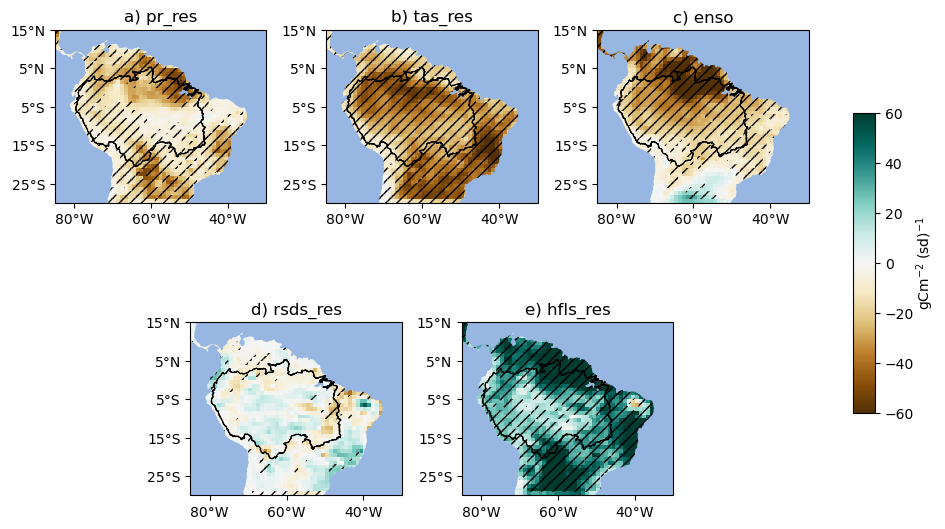

In [14]:
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scenario = "historical"

if scenario == "historical":
    mean_plot = [coef_ridge_hist_pr_mean,coef_ridge_hist_tas_mean,coef_ridge_hist_enso_mean,coef_ridge_hist_rsds_mean,coef_ridge_hist_hfls_mean]
    hatch_plot = [mm_sign_pr_hist, mm_sign_tas_hist,mm_sign_enso_hist,mm_sign_rsds_hist,mm_sign_hfls_hist]

if scenario == "ssp585":
    mean_plot = [coef_ridge_ssp_pr_mean,coef_ridge_ssp_tas_mean,coef_ridge_ssp_enso_mean,coef_ridge_ssp_rsds_mean,coef_ridge_ssp_hfls_mean]
    hatch_plot = [mm_sign_pr_ssp, mm_sign_tas_ssp,mm_sign_enso_ssp,mm_sign_rsds_ssp,mm_sign_hfls_ssp]

if scenario == "delta":
    mean_plot = [coef_ridge_ssp_pr_mean - coef_ridge_hist_pr_mean,
                    coef_ridge_ssp_tas_mean - coef_ridge_hist_tas_mean,
                    coef_ridge_ssp_enso_mean - coef_ridge_hist_enso_mean,
                    coef_ridge_ssp_rsds_mean -coef_ridge_hist_rsds_mean,
                    coef_ridge_ssp_hfls_mean - coef_ridge_hist_hfls_mean]
letter = ["a) ", "b) ", "c) ", "d) ", "e) "]
reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

# Create the figure 
fig = plt.figure(figsize=(11, 6)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 8)

for i, ax in enumerate(mean_plot):

    if i < 3:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if i > 2:
        ax = fig.add_subplot(gs[1, 2 * i - 5 : 2 * i - 3], projection = ccrs.PlateCarree())

    lats = mean_plot[i].lat; lons = mean_plot[i].lon
    map1 = mean_plot[i].plot.pcolormesh(vmin=-60, vmax=60, cmap="BrBG", transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    if scenario == "historical" or scenario == "ssp585":
        map = ax.pcolor(lons, lats, hatch_plot[i], hatch = '///', transform = ccrs.PlateCarree(), alpha = 0)
    else:
        None
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
    # Longitude labels
    ax.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    # Latitude labels
    ax.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    if i == 2:
        ax.set_title(letter[i] + mean_plot[i].name)
    else:
        ax.set_title(letter[i] + mean_plot[i].name + "_res")

fig.subplots_adjust(bottom=0.0, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.0)
fig.tight_layout()
cbar_ax = fig.add_axes([0.78, 0.25, 0.02, 0.5]) # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax)
clb.set_label("gCm$^{-2}$ (sd)$^{-1}$",fontsize= 10,labelpad = 0.2)
title = "MM Ridge Regression coefficients agreement - " + scenario
# fig.suptitle(title, x = 0.45, y = 1, fontsize = 14)

# Output file
output_file = os.path.join(out_path, title) + "_c_10outof13.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

Plot t-test Delta coefficient

In [14]:
coef_pr_hist = mask_shape(coef_ridge_hist_pr_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_tas_hist = mask_shape(coef_ridge_hist_tas_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_enso_hist = mask_shape(coef_ridge_hist_enso_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_rsds_hist = mask_shape(coef_ridge_hist_rsds_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_hfls_hist = mask_shape(coef_ridge_hist_hfls_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")

coef_pr_ssp = mask_shape(coef_ridge_ssp_pr_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_tas_ssp = mask_shape(coef_ridge_ssp_tas_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_enso_ssp = mask_shape(coef_ridge_ssp_enso_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_rsds_ssp = mask_shape(coef_ridge_ssp_rsds_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")
coef_hfls_ssp = mask_shape(coef_ridge_ssp_hfls_mean,geodf).sel(region = 1).stack(cell = ["lon","lat"]).dropna(dim = "cell")

In [15]:
# Convert to pandas dataframe
import pandas as pd

df_coef_pr_hist = coef_pr_hist.to_dataframe()[["pr"]]; df_coef_tas_hist = coef_tas_hist.to_dataframe()[["tas"]]
df_coef_enso_hist = coef_enso_hist.to_dataframe()[["enso"]]; df_coef_rsds_hist = coef_rsds_hist.to_dataframe()[["rsds"]]
df_coef_hfls_hist = coef_hfls_hist.to_dataframe()[["hfls"]]

df_hist = pd.concat([df_coef_pr_hist, df_coef_tas_hist, df_coef_enso_hist, df_coef_rsds_hist, df_coef_hfls_hist], axis = 1)
df_hist = df_hist.rename(columns = {"pr":"pr_res","tas": "tas_res","enso": "enso","rsds": "rsds_res","hfls": "hfls_res"})

df_coef_pr_ssp = coef_pr_ssp.to_dataframe()[["pr"]]; df_coef_tas_ssp = coef_tas_ssp.to_dataframe()[["tas"]]
df_coef_enso_ssp = coef_enso_ssp.to_dataframe()[["enso"]]; df_coef_rsds_ssp = coef_rsds_ssp.to_dataframe()[["rsds"]]
df_coef_hfls_ssp = coef_hfls_ssp.to_dataframe()[["hfls"]]

df_ssp = pd.concat([df_coef_pr_ssp, df_coef_tas_ssp, df_coef_enso_ssp, df_coef_rsds_ssp, df_coef_hfls_ssp], axis = 1)
df_ssp = df_ssp.rename(columns = {"pr":"pr_res","tas": "tas_res","enso": "enso","rsds": "rsds_res","hfls": "hfls_res"})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

tas_res_historical v.s. tas_res_ssp585: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.186e-04 U_stat=1.359e+05
pr_res_historical v.s. pr_res_ssp585: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.778e-26 U_stat=2.173e+05
enso_historical v.s. enso_ssp585: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.260e-50 U_stat=2.415e+05
rsds_res_historical v.s. rsds_res_ssp585: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.494e-94 U_stat=4.623e+04
hfls_res_historical v.s. hfls_res_ssp585: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.573e+05


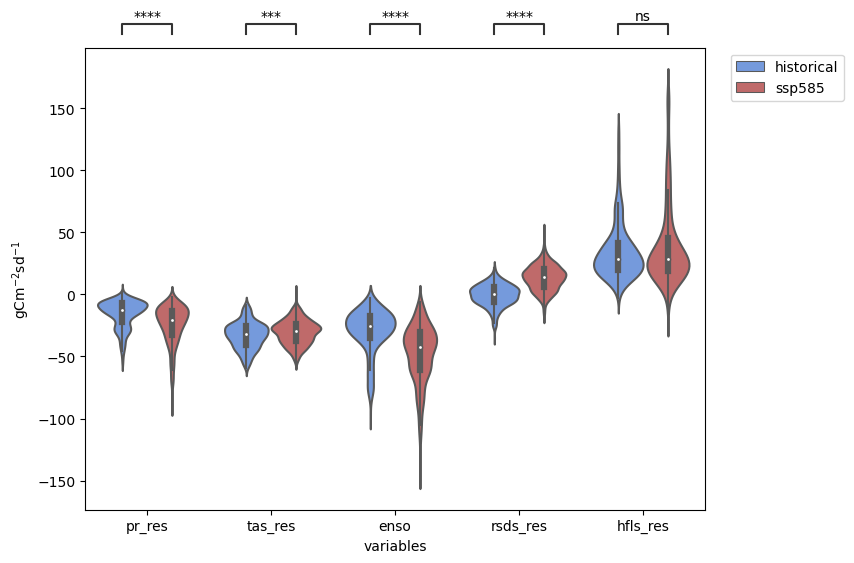

In [19]:
import seaborn as sns
from statannot import add_stat_annotation

df = pd.DataFrame([[label, val, 'historical'] for label, values in df_hist.items() for val in values]
                  + [[label, val, 'ssp585'] for label, values in df_ssp.items() for val in values],
                  columns=['variables', 'coefficient', 'scenario'])

order = ["pr_res", "tas_res", "enso", "rsds_res", "hfls_res"]

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, x='variables', y='coefficient', hue='scenario', palette=['cornflowerblue', 'indianred'], order = order, ax=ax)
ax.set(xlabel='variables', ylabel='gCm$^{-2}$sd$^{-1}$')  
add_stat_annotation(ax, data=df, x='variables', y='coefficient', hue='scenario', order=order,
                    box_pairs=[(("enso", "historical"), ("enso", "ssp585")), (("pr_res", "historical"), ("pr_res", "ssp585")), (("rsds_res", "historical"), ("rsds_res", "ssp585")), 
                               (("tas_res", "historical"), ("tas_res", "ssp585")), (("hfls_res", "historical"), ("hfls_res", "ssp585"))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

title = "predictors importance_MM_masked amazon"
output_file = os.path.join(out_path, title) + "_c_violin_MW_test.png"
plt.savefig(output_file, bbox_inches='tight')


## Plot model predictor importance agreement

In [24]:

coef_ridge_hist_imp = []
for i,item in enumerate(coef_ridge_hist):
    content = xr.DataArray(data=None, coords=[item.lon, item.lat], dims=["lon", "lat"])

    provapr = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 0))
    provatas = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 1))
    provaenso = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 2))
    provarsds = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 3))
    provahfls = (np.abs(coef_ridge_hist[i]).max(dim = "coefficients") == np.abs(coef_ridge_hist[i]).sel(coefficients = 4))

    content = xr.where(provapr, 900, None).astype("float64")
    content = xr.where(provatas, 901, content).astype("float64")
    content = xr.where(provaenso, 902, content).astype("float64")
    content = xr.where(provarsds, 903, content).astype("float64")
    content = xr.where(provahfls, 904, content).astype("float64")

    coef_ridge_hist_imp.append(content)

In [25]:

coef_ridge_ssp_imp = []
for i,item in enumerate(coef_ridge_ssp):
    content = xr.DataArray(data=None, coords=[item.lon, item.lat], dims=["lon", "lat"])

    provapr = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 0))
    provatas = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 1))
    provaenso = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 2))
    provarsds = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 3))
    provahfls = (np.abs(coef_ridge_ssp[i]).max(dim = "coefficients") == np.abs(coef_ridge_ssp[i]).sel(coefficients = 4))

    content = xr.where(provapr, 900, None).astype("float64")
    content = xr.where(provatas, 901, content).astype("float64")
    content = xr.where(provaenso, 902, content).astype("float64")
    content = xr.where(provarsds, 903, content).astype("float64")
    content = xr.where(provahfls, 904, content).astype("float64")
    
    coef_ridge_ssp_imp.append(content)

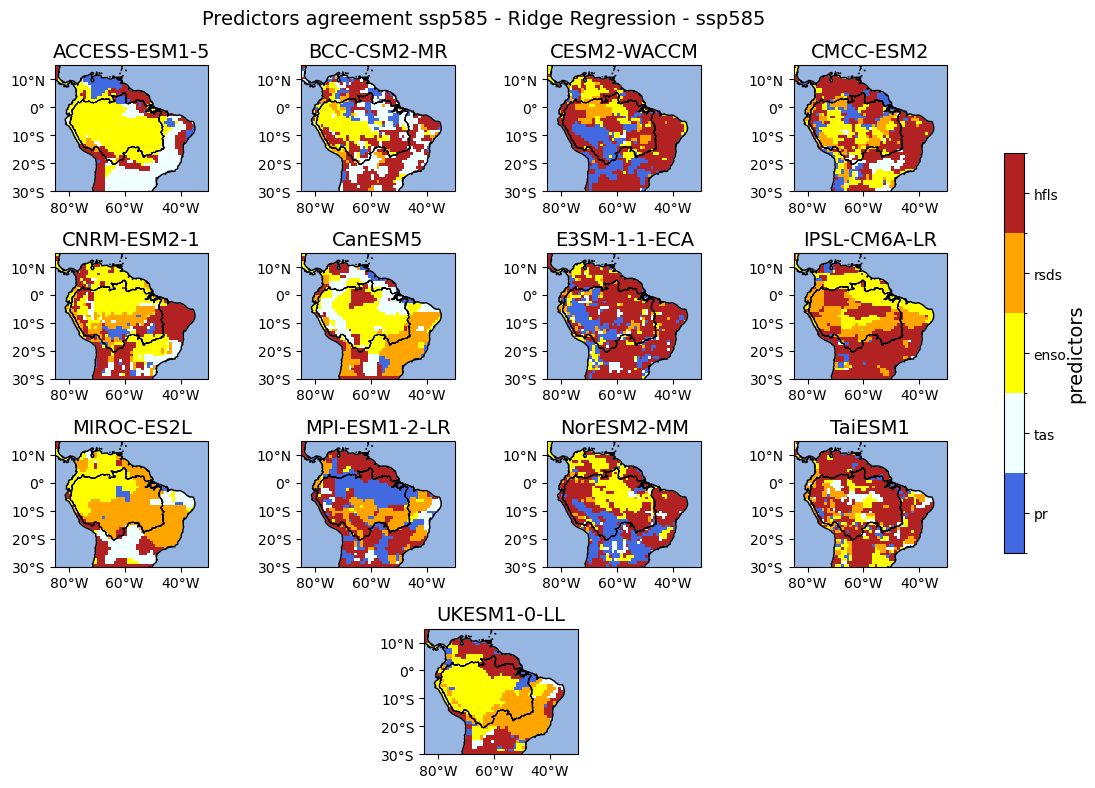

In [30]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

seas = "DJF"

# --- Define data to plot
to_plot = "coef_imp_ssp"

if to_plot == "coef_imp_hist":
    data_plot = coef_ridge_hist_imp.copy()
    cbar_label = 'predictors'
    cmap = colors.ListedColormap(['royalblue', 'azure', 'yellow', 'orange', 'firebrick'])
    bounds = np.arange(900,905.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    title = 'Predictors agreement historical - Ridge Regression - ' + "historical"

if to_plot == "coef_imp_ssp":
    data_plot = coef_ridge_ssp_imp.copy()
    cbar_label = 'predictors'
    cmap = colors.ListedColormap(['royalblue', 'azure', 'yellow', 'orange', 'firebrick'])
    bounds = np.arange(900,905.5,1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    title = 'Predictors agreement ssp585 - Ridge Regression - ' + "ssp585"

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    map = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False, norm = norm)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle(title, fontsize = 14)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.3, 0.02, 0.5])                     # Left, Bottom, Width, Height
bounds = np.arange(900.5,905.5,1)
clb = plt.colorbar(map, cax=cbar_ax, ticks=bounds)
clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(['pr', 'tas', 'enso', 'rsds', 'hfls'])

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()